In [2]:
import tensorflow as tf 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt 
import numpy as np 
#加载图片，并对图片进行相应操作
base_dir = '/home/liangyi/workplace/python/MachineLearning/NeuralNetwork/cat-and-dog/'
train_cat_dir = os.path.join(base_dir, 'training_set/cats')
train_dog_dir = os.path.join(base_dir, 'training_set/dogs')
test_cat_dir = os.path.join(base_dir, 'test_set/cats')
test_dog_dir = os.path.join(base_dir, 'test_set/dogs')

/home/liangyi/workplace/python/MachineLearning/NeuralNetwork/cat-and-dog/training_set/dogs/dog.2893.jpg


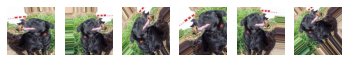

In [3]:
#对图片进行操作
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, 
                             height_shift_range=0.2, #注意换行这个地方千万不能加空格
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
fnames = [os.path.join(train_dog_dir, fname) for fname in os.listdir(train_dog_dir)]
img_path = fnames[1]
#img_path = train_dog_dir[1]
print(img_path)


img = image.load_img(img_path, target_size=(150,150))
img = image.img_to_array(img)
#对图片做6种变换
img = img.reshape((1,) + img.shape)
i = 0
f, ax = plt.subplots(1, 6)
for batch in datagen.flow(img, batch_size=1):
    imgplot = ax[i].imshow(image.array_to_img(batch[0]))
    ax[i].axis('off')
    i += 1
    if i % 6 == 0:
        break
plt.show()



In [4]:
#设置CNN，（150，150，3），32，64，128，128，512，1
from tensorflow.keras import layers
from tensorflow.keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [7]:
from tensorflow.keras import preprocessing
#将图片加载到内存中
path_cats = []
for path in os.listdir(train_cat_dir):
    if '.jpg' in path:
        path_cats.append(os.path.join(train_cat_dir, path))
path_dogs = []
for path in os.listdir(train_dog_dir):
    if '.jpg' in path:
        path_dogs.append(os.path.join(train_dog_dir, path))

#将training图片转换为（150，150）的二维数组.猫3000张，狗3000张
training_set = np.zeros((6000,150,150,3), dtype='float32')
train_dog_imgs = 3000
train_cat_imgs = 3000
for i in range(train_dog_imgs):
    img = preprocessing.image.load_img(path_dogs[i], target_size = (150,150))
    training_set[i] = preprocessing.image.img_to_array(img)
for j in range(train_cat_imgs):
    img = preprocessing.image.load_img(path_cats[j], target_size = (150,150))
    training_set[j+train_dog_imgs] = preprocessing.image.img_to_array(img)
#准备2000张图片作为val_set,猫狗各1000张
val_set = np.zeros((2000,150,150,3), dtype='float32')
val_dog_imgs = 1000
val_cat_imgs = 1000
for i in range(val_dog_imgs):
    path = path_dogs[i+train_dog_imgs]
    img = preprocessing.image.load_img(path, target_size = (150,150))
    val_set[i] = preprocessing.image.img_to_array(img)
for j in range(val_cat_imgs):
    path = path_cats[j+train_cat_imgs]
    img = preprocessing.image.load_img(path, target_size = (150,150))
    val_set[j+val_cat_imgs] = preprocessing.image.img_to_array(img)

#设置猫狗图片的标签，狗为1，猫为0
train_labels = np.zeros((3000, ))
train_labels = np.concatenate((train_labels, np.ones(3000, )))
val_labels = np.zeros((1000,))
val_labels = np.concatenate((val_labels, np.ones(1000, )))

In [9]:
training_set = tf.convert_to_tensor(training_set, dtype='float32')
val_set = tf.convert_to_tensor(val_set, dtype='float32')
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)

In [11]:
print(tf.is_tensor(training_set))

True


In [13]:
#将图片的像素转换到[0,1]之间
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, 
                             height_shift_range=0.2, #注意换行这个地方千万不能加空格
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow(training_set, train_labels, batch_size = 32)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(val_set, val_labels, batch_size = 32)

In [14]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data=val_generator, validation_steps=50)

Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,148,148] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv2d/Relu (defined at <ipython-input-14-0cb5ffadfe10>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1179]

Function call stack:
train_function
